# C9orf72 age at onset analysis
This notebook contains the source code to perform the age at onset analysis of the C9orf72 manuscript. The source data and analysis exist in the original folders but I want to create a folder to keep the essential data and code for Github and future references.

## Directories

In [2]:
%%bash
echo "Notebook directory"
pwd
echo
cd 2022_01_14.ManuscriptRepo
echo "Notebook data"
pwd 

Notebook directory
/gpfs/gsfs11/users/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO

Notebook data
/gpfs/gsfs11/users/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2022_01_14.ManuscriptRepo


## Datasets

Datasets used in this study (updated on June 11th)

1. **Reference** = van Rheenen (*van Rheenen et al., 2016*).


2. **Training** (*Nicolas et al., 2018*) = ALS (n= 7,037) & CONTROLS (n=34,236) from array-based genotyping data, only non-C9 carriers(total n =41273).


3. **Test**(*Saez-Atienzar et al., 2021; Nicolas et al., 2018; Dewan et al., 2021*)= ALS/FTD C9 carriers (817) from array-based genotyping data and whole-genome sequencing data.


4. **Replication** (unpublished, Isabella Fogh perform the score analysis and she provided the profile file) =699 ALS/FTD C9 carriers from array-based genotyping.

## Code

### Generate the final samples for the training cohort 
This is the cohort for the paper, in which only *C9orf72* cases are used from Resolution (whole genome sequencing data)

In [5]:
%%bash
cd /data/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2021-03-26.MergingDatasets/PCs/

module load R/4.0.0
R --vanilla --no-save
require(dplyr)
require(tidyverse)
require(ggplot2)
require(data.table)
require(RColorBrewer)

###########################################    New update 06/11/2021   #################################################

# MERGED DATASET PHENO FILE,
# I am going to create a training dataset to include only ALS (non-C9) cases and dbgap controls.
# Our "testing" is ALS/FTD C9 only (both from WGS and chip arrays) 


#Read the merged covariate file
data = fread("missing.COVARIATES.MERGED.C9KnownStatus.noDups.LNGonly.UNRELATED.txt", header =T)


# All individuals
dim(data)

# Select only individuals with known age at onset
data = filter(data, age_at_onset > 1)

# Only individuals with known age at onset
dim(data)

# Individuals removed without age at onset
47249- 47119  

table(data$diagnosis)
data2 <- data %>% mutate (diagnosis3 = ifelse(diagnosis == "Control" |  diagnosis == "control", "Control", 
                                                       ifelse(diagnosis == "ALS" | diagnosis == "FTD", "Case", "no")))


table(data2$c9orf72_status)
data3 <- data2 %>% mutate (diagnosis2 = ifelse(diagnosis3 == "Case" & c9orf72_status == "WT", "Case_WT", 
                                                      ifelse(diagnosis3 == "Case" & c9orf72_status == "EXP", "Case_EXP",
                                                      ifelse(diagnosis3 == "Case" & c9orf72_status == "Exp", "Case_EXP",
                                                            ifelse(diagnosis3 == "Control" & c9orf72_status == "WT", "Control_WT",
                                                                  ifelse(diagnosis3 == "Control" & c9orf72_status == "EXP", "Control_EXP",
                                                                   ifelse(diagnosis3 == "Control" & c9orf72_status == "Exp", "Control_EXP","no")))))))



table(data3$diagnosis2)
data4 <- data3 %>% mutate (diagnosis4 = ifelse(diagnosis == "Control" |  diagnosis == "control", "Control", 
                                                       ifelse(diagnosis == "ALS", "ALS",
                                                       ifelse(diagnosis == "FTD", "FTD","no"))))


table(data4$diagnosis4)

data4 = data4 %>% mutate (c9orf72_status2 = ifelse(c9orf72_status == "WT", "WT",
                                                       ifelse(c9orf72_status == "EXP", "EXP",
                                                       ifelse(c9orf72_status == "Exp", "EXP","no"))))


data = data4
table(data$dataset)

# ALS DATASET = 41939 
# FTD DATASET = 5180


# This is going to be my training dataset to build best PRS model
ALS = filter(data, dataset == "ALS")
dim(ALS)


ALSnonC9 = filter(ALS, diagnosis2 != "Case_EXP")


# ALS WITH ALL C9 CASES
dim(ALS)

# ALS WITHOUT C9
dim(ALSnonC9)

# ALS C9
#41939 - 41273 = 666
# save the FID for ALS without C9. This is my training dataset.
table(ALSnonC9$diagnosis, ALSnonC9$dataset)
dim(ALSnonC9)
ALSnonC9$FID_IID = paste(ALSnonC9$FID, ALSnonC9$IID, sep = "_")

FID = select(ALSnonC9, FID, IID)
dim(FID)
#write.table(FID, "/gpfs/gsfs11/users/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2022_01_14.ManuscriptRepo/TrainingDataset.ALSwoC9.txt", sep="\t",quote=F, col.names=F,row.names=F)

FID$FID_IID = paste(FID$FID, FID$IID, sep = "_")


FID$FID_IID2 = FID$FID_IID
FID_IID2 = select(FID, FID_IID, FID_IID2) 
#write.table(FID_IID2, "/gpfs/gsfs11/users/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2022_01_14.ManuscriptRepo/FID_IID.TrainingDataset.ALSwoC9.txt", sep="\t",quote=F, col.names=F,row.names=F)

# Selecting the features to keep

alstobind = select(ALSnonC9, FID, IID, FID_IID,MAT, PAT, SEX, PHENO, diagnosis, gender, age_at_onset, c9orf72_status, Cohort, dataset, FID_IID, subtype,
GENDER, diagnosis3, diagnosis2, diagnosis4)

ALLc9 = filter(data, diagnosis2 == "Case_EXP")
dim(ALLc9)
ALLc9$FID_IID = ALLc9$FID

FID = select(ALLc9, FID, IID)
dim(FID)
#write.table(ALLc9, "/gpfs/gsfs11/users/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2022_01_14.ManuscriptRepo/replication.C9dataset.ALSandFTDallC9.txt", sep="\t",quote=F, col.names=F,row.names=F)


# concatenate names
ALLc9 = filter(data, diagnosis2 == "Case_EXP")
dim(ALLc9)
FID = select(ALLc9, FID, IID)
dim(FID)
#write.table(ALLc9, "/gpfs/gsfs11/users/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2022_01_14.ManuscriptRepo/replication.C9dataset.ALSandFTDallC9.txt", sep="\t",quote=F, col.names=F,row.names=F)

# Selecting the features to keep
alsc9 = filter(ALLc9, dataset == "ALS")
dim(alsc9)

alsC9tobind = select(alsc9, FID, IID, FID_IID,MAT, PAT, SEX, PHENO, diagnosis, gender, age_at_onset, c9orf72_status, Cohort, dataset, FID_IID, subtype,
GENDER, diagnosis3, diagnosis2, diagnosis4)


binded = rbind(alstobind,alsC9tobind)
table(binded$diagnosis2, binded$diagnosis4)

ftdc9 = filter(ALLc9, dataset == "FTD")


ftdC9tobind = select(ftdc9, FID, IID, FID_IID,MAT, PAT, SEX, PHENO, diagnosis, gender, age_at_onset, c9orf72_status, Cohort, dataset, FID_IID, subtype,
GENDER, diagnosis3, diagnosis2, diagnosis4)

binded2 = rbind(binded,ftdC9tobind)
dim(binded2)



toprint = select (binded2, FID, IID, FID_IID,MAT, PAT, SEX, PHENO, diagnosis, gender, age_at_onset, c9orf72_status, Cohort, dataset, FID_IID, subtype,
GENDER, diagnosis3, diagnosis2, diagnosis4)
#write.table(toprint, "/gpfs/gsfs11/users/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2022_01_14.ManuscriptRepo/Trainingandc9.datasets.forCOV.txt", sep="\t",quote=F, col.names=T,row.names=F)


[+] Loading gcc  9.2.0  ... 
[+] Loading GSL 2.6 for GCC 9.2.0 ...
[-] Unloading gcc  9.2.0  ... 
[+] Loading gcc  9.2.0  ... 
[+] Loading openmpi 3.1.4  for GCC 9.2.0 
[+] Loading ImageMagick  7.0.8  on cn0912 
[+] Loading HDF5  1.10.4 
[-] Unloading gcc  9.2.0  ... 
[+] Loading gcc  9.2.0  ... 
[+] Loading NetCDF 4.7.4_gcc9.2.0 
[+] Loading pandoc  2.17.1.1  on cn0912 
[+] Loading pcre2 10.21  ... 
[+] Loading R 4.0.0 



R version 4.0.0 (2020-04-24) -- "Arbor Day"
Copyright (C) 2020 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

> require(dplyr)


Loading required package: dplyr

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
package ‘dplyr’ was built under R version 4.0.3 
Loading required package: tidyverse


> require(tidyverse)


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ stringr 1.4.0
✔ tidyr   1.2.0     ✔ forcats 0.5.0
✔ readr   2.1.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Warning messages:
1: package ‘ggplot2’ was built under R version 4.0.3 
2: package ‘tibble’ was built under R version 4.0.3 
3: package ‘tidyr’ was built under R version 4.0.5 
4: package ‘readr’ was built under R version 4.0.3 


> require(ggplot2)
> require(data.table)


Loading required package: data.table

Attaching package: ‘data.table’

The following object is masked from ‘package:purrr’:

    transpose

The following objects are masked from ‘package:dplyr’:

    between, first, last

Warning message:
package ‘data.table’ was built under R version 4.0.3 


> require(RColorBrewer)


Loading required package: RColorBrewer


> 
> ###########################################    New update 06/11/2021   #################################################
> 
> # MERGED DATASET PHENO FILE,
> # I am going to create a training dataset to include only ALS (non-C9) cases and dbgap controls.
> # Our "testing" is ALS/FTD C9 only (both from WGS and chip arrays) 
> 
> 
> #Read the merged covariate file
> data = fread("missing.COVARIATES.MERGED.C9KnownStatus.noDups.LNGonly.UNRELATED.txt", header =T)
> 
> 
> # All individuals
> dim(data)
[1] 42095    35
> 
> # Select only individuals with known age at onset
> data = filter(data, age_at_onset > 1)
> 
> # Only individuals with known age at onset
> dim(data)
[1] 42095    35
> 
> # Individuals removed without age at onset
> 47249- 47119  
[1] 130
> 
> table(data$diagnosis)

    ALS control     FTD 
   7703   34241     151 
> data2 <- data %>% mutate (diagnosis3 = ifelse(diagnosis == "Control" |  diagnosis == "control", "Control", 
+                                              

### Generate Covariate file for genetic risk score
The covariate file is generate for the controls (34,236) and (7,764) cases together.

In [29]:
%%bash
module load plink/1.9.0-beta4.4
module load R/4.0.0
module load GCTA/1.92.0beta3
module load flashpca

# Prune snps
plink \
--bfile /data/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2021-03-26.MergingDatasets/Bin/missing.PC.MERGED.FINAL.hg19 \
--keep /data/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2021-03-26.MergingDatasets/PCs/Trainingandc9.datasets.forCOV.txt \
--allow-no-sex \
--maf 0.01 \
--geno 0.01 \
--hwe 5e-6 \
--autosome \
--exclude /data/NDRS_LNG/ALS_imputationHG19_withChrX_2020/scripts/exclusion_regions_hg19.txt \
--make-bed \
--out 2021-03-26.MergingDatasets/PCs/2021-06-11.missing.merged_ONLYknownstatus.ALS_LNGonly.UNRELATED_filter \
--memory 119500 --threads 19

plink \
--bfile 2021-03-26.MergingDatasets/PCs/2021-06-11.missing.merged_ONLYknownstatus.ALS_LNGonly.UNRELATED_filter \
--allow-no-sex \
--geno 0.01 \
--maf 0.05 \
--indep-pairwise 1000 10 0.02 \
--out 2021-03-26.MergingDatasets/PCs/2021-06-11.missing.merged_ONLYknownstatus.ALS_LNGonly.UNRELATED_filter_pruning \
--memory 119500 --threads 19

plink \
--bfile 2021-03-26.MergingDatasets/PCs/2021-06-11.missing.merged_ONLYknownstatus.ALS_LNGonly.UNRELATED_filter \
--allow-no-sex \
--extract 2021-03-26.MergingDatasets/PCs/2021-06-11.missing.merged_ONLYknownstatus.ALS_LNGonly.UNRELATED_filter_pruning.prune.in \
--keep-allele-order \
--make-bed \
--out 2021-03-26.MergingDatasets/PCs/2021-06-11.pruned.missing.merged_ONLYknownstatus.ALS_LNGonly.UNRELATED \
--memory 119500 --threads 19;

# Calculate/generate PCs based on pruned data set
cd 2021-03-26.MergingDatasets/PCs
flashpca --bfile 2021-06-11.pruned.missing.merged_ONLYknownstatus.ALS_LNGonly.UNRELATED -d 20 --suffix _2021-06-11.missing.merged_ONLYknownstatus.ALS_LNGonly.UNRELATED_forPCA --numthreads 19

# Move all log files to a new folder
#mkdir logFiles
mv *.log logFiles

# Remove intermediate files
rm 2021-06-11.missing.merged_ONLYknownstatus.ALS_LNGonly.UNRELATED_filter.bed
rm 2021-06-11.missing.merged_ONLYknownstatus.ALS_LNGonly.UNRELATED_filter.bim
rm 2021-06-11.missing.merged_ONLYknownstatus.ALS_LNGonly.UNRELATED_filter.fam
rm 2021-06-11.missing.merged_ONLYknownstatus.ALS_LNGonly.UNRELATED_filter_pruning.prune.in
rm 2021-06-11.missing.merged_ONLYknownstatus.ALS_LNGonly.UNRELATED_filter_pruning.prune.out




PLINK v1.90b4.4 64-bit (21 May 2017)           www.cog-genomics.org/plink/1.9/
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to 2021-03-26.MergingDatasets/PCs/2021-06-11.missing.merged_ONLYknownstatus.ALS_LNGonly.UNRELATED_filter.log.
Options in effect:
  --allow-no-sex
  --autosome
  --bfile /data/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2021-03-26.MergingDatasets/Bin/missing.PC.MERGED.FINAL.hg19
  --exclude /data/NDRS_LNG/ALS_imputationHG19_withChrX_2020/scripts/exclusion_regions_hg19.txt
  --geno 0.01
  --hwe 5e-6
  --keep /data/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2021-03-26.MergingDatasets/PCs/Trainingandc9.datasets.forCOV.txt
  --maf 0.01
  --make-bed
  --memory 119500
  --out 2021-03-26.MergingDatasets/PCs/2021-06-11.missing.merged_ONLYknownstatus.ALS_LNGonly.UNRELATED_filter
  --threads 19

1031832 MB RAM detected; reserving 119500 MB for main workspace.
191589 variants loaded from .bim file.
61875 people (25012 males, 36863 females) loaded 

[+] Loading plink  1.9.0-beta4.4  on cn0630 
[-] Unloading gcc  9.2.0  ... 
[-] Unloading GSL 2.6 for GCC 9.2.0 ...
[-] Unloading openmpi 4.0.5  for GCC 9.2.0 
[-] Unloading ImageMagick  7.0.8  on cn0630 
[-] Unloading HDF5  1.10.4 
[-] Unloading NetCDF 4.7.4_gcc9.2.0 
[-] Unloading pandoc  2.13  on cn0630 
[-] Unloading pcre2 10.21  ... 
[-] Unloading R 4.0.5 
[+] Loading gcc  9.2.0  ... 
[+] Loading GSL 2.6 for GCC 9.2.0 ...
[-] Unloading gcc  9.2.0  ... 
[+] Loading gcc  9.2.0  ... 
[+] Loading openmpi 3.1.4  for GCC 9.2.0 
[+] Loading ImageMagick  7.0.8  on cn0630 
[+] Loading HDF5  1.10.4 
[-] Unloading gcc  9.2.0  ... 
[+] Loading gcc  9.2.0  ... 
[+] Loading NetCDF 4.7.4_gcc9.2.0 
[+] Loading pandoc  2.13  on cn0630 
[+] Loading pcre2 10.21  ... 
[+] Loading R 4.0.0 

The following have been reloaded with a version change:
  1) R/4.0 => R/4.0.0

[+] Loading GCTA  1.92.0beta3 
[+] Loading flashpca  2.0  on cn0630 


# Making an updated COVARIATE FILE

In [3]:
%%bash
# Create covariates file
cd /data/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2021-03-26.MergingDatasets/PCs/
module load R/4.0.0
R --vanilla --no-save

# Load libraries
require(data.table)
require(tidyverse)

# All samples (related + unrelated; but no dups)
## Read in files
pc <- fread("pcs_2021-06-11.missing.merged_ONLYknownstatus.ALS_LNGonly.UNRELATED_forPCA", header=T)
dim(pc)
pheno = fread("Trainingandc9.datasets.forCOV.txt", header = T)


data1 <- merge(pheno, pc,by=c("FID","IID"))

data = data1

dim(data)
table(data$dataset, data$diagnosis, data$c9orf72_status)

# Add two new columns named "training" and "replication"

write.table(data, "/gpfs/gsfs11/users/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2022_01_14.ManuscriptRepo/UPDATED.COV.ALSplusALSFTD.C9.txt", sep="\t",quote=F, col.names=T,row.names=F)

datatrial = filter (data, diagnosis2 == "Case_EXP" & diagnosis4 == "ALS")

dim(datatrial)
# Save covariate file for PRSice2
#data2 = select(data, FID_IID2, FID_IID, SEX, age_at_onset, PC1, PC2, PC3, PC4, PC5, PC6, PC7, PC8, PC9, PC10, PC11, PC12, PC13, PC14, PC15, PC16, PC17, PC18, PC19, PC20)
#write.table(data2, "toPRSice2.UPDATED.COV.ALSplusALSFTD.C9.txt", sep="\t",quote=F, col.names=T,row.names=F)

#table(data$diagnosis2)
#table(data$diagnosis3)
#table(data$diagnosis4)

# Add two new columns named "training" and "replication"
#data3 <- data %>% mutate (training = ifelse(dataset == "ALS" |  diagnosis2 == "Case_WT" | diagnosis4 == "Control", "yes", "no"))

#table(data3$training)


[+] Loading gcc  9.2.0  ... 
[+] Loading GSL 2.6 for GCC 9.2.0 ...
[-] Unloading gcc  9.2.0  ... 
[+] Loading gcc  9.2.0  ... 
[+] Loading openmpi 3.1.4  for GCC 9.2.0 
[+] Loading ImageMagick  7.0.8  on cn0912 
[+] Loading HDF5  1.10.4 
[-] Unloading gcc  9.2.0  ... 
[+] Loading gcc  9.2.0  ... 
[+] Loading NetCDF 4.7.4_gcc9.2.0 
[+] Loading pandoc  2.17.1.1  on cn0912 
[+] Loading pcre2 10.21  ... 
[+] Loading R 4.0.0 



R version 4.0.0 (2020-04-24) -- "Arbor Day"
Copyright (C) 2020 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

> 
> # Load libraries
> require(data.table)


Loading required package: data.table
Warning message:
package ‘data.table’ was built under R version 4.0.3 


> require(tidyverse)


Loading required package: tidyverse
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()
Warning messages:
1: package ‘ggplot2’ was built under R version 4.0.3 
2: package ‘tibble’ was built under R version 4.0.3 
3: package ‘tidyr’ was built under R version 4.0.5 
4: package ‘readr’ was built under R version 4.0.3 
5: package ‘dplyr’ was built under R version 4.0.3 


> 
> # All samples (related + unrelated; but no dups)
> ## Read in files
> pc <- fread("pcs_2021-06-11.missing.merged_ONLYknownstatus.ALS_LNGonly.UNRELATED_forPCA", header=T)
> dim(pc)
[1] 42090    22
> pheno = fread("Trainingandc9.datasets.forCOV.txt", header = T)
> 
> 
> data1 <- merge(pheno, pc,by=c("FID","IID"))
> 
> data = data1
> 
> dim(data)
[1] 42090    38
> table(data$dataset, data$diagnosis, data$c9orf72_status)
, ,  = EXP

     
        ALS control   FTD
  ALS   666       1     0
  FTD     0       0   151

, ,  = WT

     
        ALS control   FTD
  ALS  7037   34235     0
  FTD     0       0     0

> 
> # Add two new columns named "training" and "replication"
> 
> write.table(data, "/gpfs/gsfs11/users/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2022_01_14.ManuscriptRepo/UPDATED.COV.ALSplusALSFTD.C9.txt", sep="\t",quote=F, col.names=T,row.names=F)
> 
> datatrial = filter (data, diagnosis2 == "Case_EXP" & diagnosis4 == "ALS")
> 
> dim(datatrial)
[1] 666  38
> # Save covariate file 

### Calculate general ALS RISK in *C9orf72 non-carriers*
Binary files exclude a region of 150kb upstream/downstreat of *C9orf72* GWAS signal. This is to avoid considering risk associated to *C9orf72*.

`PRSice2 (version2.1.1.beta )is used for this analysis`

In [55]:
%%bash
cd /data/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2020-12-2.GRS/Bin/
 
#Remove +150kb upstream/downstream of the top GWAS hit SNP position (rsID3849943), Nicolas et al, 2018
echo "9 27393382 27693382 whole150kbc9orf72" > exclude150KBC9.txt

module load plink/1.9.0-beta4.4
plink \
--bfile /data/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2021-03-26.MergingDatasets/Bin/missing.MOTORNEURON_NONCARRIERS.rsID.ALSFTD.mergeddataset.FINAL.hg19 \
--exclude range exclude150KBC9.txt \
--make-bed \
--keep /data/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2021-03-26.MergingDatasets/PCs/FID_IID.TrainingDataset.ALSwoC9.txt \
--out EXCLUDED150kb_training.ALSwoC9.FINAL.hg19

PLINK v1.90b4.4 64-bit (21 May 2017)           www.cog-genomics.org/plink/1.9/
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to EXCLUDED150kb_training.ALSwoC9.FINAL.hg19.log.
Options in effect:
  --bfile /data/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2021-03-26.MergingDatasets/Bin/missing.MOTORNEURON_NONCARRIERS.rsID.ALSFTD.mergeddataset.FINAL.hg19
  --exclude range exclude150KBC9.txt
  --keep /data/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2021-03-26.MergingDatasets/PCs/FID_IID.TrainingDataset.ALSwoC9.txt
  --make-bed
  --out EXCLUDED150kb_training.ALSwoC9.FINAL.hg19

1031832 MB RAM detected; reserving 515916 MB for main workspace.
6546373 variants loaded from .bim file.
45788 people (16562 males, 29226 females) loaded from .fam.
45788 phenotype values loaded from .fam.
--exclude range: 970 variants excluded.
--exclude range: 6545403 variants remaining.
--keep: 41273 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main v

[+] Loading plink  1.9.0-beta4.4  on cn0630 


In [ ]:
# PRSice2 is run as R script, and the job is sent as a swarm

In [60]:
%%bash
# PRSice2 is run as an R script, and the job is sent as a swarm
echo "Rscript /data/LNG/pdMeta5v2/leaveOneOutPrsice/PRSice_linux/PRSice.R --cov-file /data/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2021-03-26.MergingDatasets/PCs/toPRSice2.UPDATED.COV.ALSplusALSFTD.C9.txt --out /data/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2020-12-2.GRS/Results/updated.onlyALSnonCARRIERS.wo150kb.Bestfit -t /data/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2020-12-2.GRS/Bin/EXCLUDED150kb_training.ALSwoC9.FINAL.hg19 -b /data/LNG/ALS_PATHWAYS/Summary_Statistics_GWAS_2016/vanRheenen_meta_summarystats_SaraSaez.tab --beta --snp SNP --A1 A1 --A2 A2 --stat b --se se --pvalue p --print-snp --score std --perm 1000 --prsice /data/LNG/pdMeta5v2/leaveOneOutPrsice/PRSice_linux/PRSice_linux -n 24 --binary-target T --maf 1E-2 --quantile 4 --prevalence 0.00005 --bar-levels 0.00000005,0.0000005,0.000005,0.000050,0.000500,0.005000,0.050000,0.500000,1.00000" > PRS.Bestfit.150kbexcl.UPDATEDals.swarm

swarm --file PRS.Bestfit.150kbexcl.UPDATEDals.swarm \
--logdir /data/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2020-12-2.GRS/Swarms_oe \
-t 24 -g 240 --time 240:00:00 \
--module R,

16867217


#### Summary PRS 

In [20]:
%%bash
cd /data/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2020-12-2.GRS/Results/
echo ""

echo "Best fit model Summary"

echo ""

cat updated.onlyALSnonCARRIERS.wo150kb.Bestfit.summary

echo ""

echo "LOG file"

echo ""

cat updated.onlyALSnonCARRIERS.wo150kb.Bestfit.log




Best fit model Summary

Phenotype	Set	Threshold	PRS.R2	Full.R2	Null.R2	Prevalence	Coefficient	Standard.Error	P	Num_SNP	Empirical-P
-	Base	0.0001	0.00076809	0.0564125	0.0556444	5e-05	0.117343	0.0142117	1.49621e-16	161	0.000999001

LOG file


PRSice 2.1.1.beta (10 April 2018) 
https://github.com/choishingwan/PRSice
(C) 2016-2017 Shing Wan (Sam) Choi, Jack Euesden, Cathryn M. Lewis, Paul F. O'Reilly
GNU General Public License v3

If you use PRSice in any published work, please cite:
Jack Euesden Cathryn M. Lewis Paul F. O'Reilly (2015)
PRSice: Polygenic Risk Score software.
Bioinformatics 31 (9): 1466-1468

2021-06-11 17:07:19
/data/LNG/pdMeta5v2/leaveOneOutPrsice/PRSice_linux/PRSice_linux \
    --A1 A1 \
    --A2 A2 \
    --bar-levels 0.000000,0.000000,0.000005,0.000050,0.000500,0.005000,0.050000,0.500000,1.000000 \
    --base /data/LNG/ALS_PATHWAYS/Summary_Statistics_GWAS_2016/vanRheenen_meta_summarystats_SaraSaez.tab \
    --beta  \
    --binary-target T \
    --clump-kb 250 \
    --c

#### Suplementaty Table S1

In [6]:
%%bash
#mkdir 2021_10_01.C9orf72.Manuscript
cd 2021_10_01.C9orf72.Manuscript
pwd

cd /data/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2020-12-2.GRS/Results/
grep "Y" updated.onlyALSnonCARRIERS.wo150kb.Bestfit.snps > 2021_10_01.SupTable1.tab

scp 2021_10_01.SupTable1.tab /gpfs/gsfs11/users/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2021_10_01.C9orf72.Manuscript
cd /gpfs/gsfs11/users/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2021_10_01.C9orf72.Manuscript

echo ""

echo "SNPs"

echo ""

wc -l 2021_10_01.SupTable1.tab

/gpfs/gsfs11/users/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2021_10_01.C9orf72.Manuscript

SNPs

161 2021_10_01.SupTable1.tab


### Calculate score in *C9orf72* cohort: test dataset
This dataset is composed of 817 cases including ALS and FTD. From those, 666 were ALS patients from chip genotyping (Neurochip) and 151 were ALS/FTD from whole genome sequencing data.

#### Generate weighted allele file using the refer

In [7]:
%%bash
cd /data/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2020-12-2.GRS/Data
module load R/4.0.0
R --vanilla --no-save
# Load libraries
require(data.table)
require(tidyverse)
require(dplyr)
data = fread("/data/LNG/ALS_PATHWAYS/Summary_Statistics_GWAS_2016/vanRheenen_meta_summarystats_SaraSaez.tab",header=T)
data2 = fread("/data/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2020-12-2.GRS/Results/yes.merged.noncarriers.wo150kb.Bestfit.snps", header = F) 
data2 = rename(data2,c('SNP'='V1', 'chr' = 'V2', 'hg19.pos' = 'V3'))
merged = merge(data2, data, by="SNP")
data3 = select(merged,SNP, chr, hg19.pos, A1, A2, b, se, p)
data3$A1 = toupper(data3$A1)
data3$A2 = toupper(data3$A2)

# 161 SNPS, excluding C9orf72 region (the file is called 162 because of the header)
#write.table(data3, "Bestfit.162merged.variants.tab", quote = F, sep = " ", col.names = T, row.names = F)
data4 = select(data3, SNP, A1, b)
#write.table(data4, "/gpfs/gsfs11/users/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2022_01_14.ManuscriptRepo/ToScore.162merged.header.tab", quote = F, sep = " ", col.names = T, row.names = F)
#write.table(data4, "/gpfs/gsfs11/users/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2022_01_14.ManuscriptRepo/ToScore.162merged.tab", quote = F, sep = " ", col.names = F, row.names = F)

# 166 SNPs
data = fread("/data/LNG/ALS_PATHWAYS/Summary_Statistics_GWAS_2016/vanRheenen_meta_summarystats_SaraSaez.tab",header=T)
data2 = fread("/data/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2020-12-2.GRS/Results/yes.166.merged.noncarriers.Bestfit.snps", header = F) 
data2 = rename(data2,c('SNP'='V1', 'chr' = 'V2', 'hg19.pos' = 'V3'))
merged = merge(data2, data, by="SNP")
data3 = select(merged,SNP, chr, hg19.pos, A1, A2, b, se, p)
data3$A1 = toupper(data3$A1)
data3$A2 = toupper(data3$A2)
#write.table(data3, "Bestfit.166merged.variants.tab", quote = F, sep = " ", col.names = T, row.names = F)
data4 = select(data3, SNP, A1, b)
#write.table(data4, "/gpfs/gsfs11/users/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2022_01_14.ManuscriptRepo/ToScore.166merged.header.tab", quote = F, sep = " ", col.names = T, row.names = F)
#write.table(data4, "/gpfs/gsfs11/users/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2022_01_14.ManuscriptRepo/ToScore.166merged.tab", quote = F, sep = " ", col.names = F, row.names = F)

[+] Loading gcc  9.2.0  ... 
[+] Loading GSL 2.6 for GCC 9.2.0 ...
[-] Unloading gcc  9.2.0  ... 
[+] Loading gcc  9.2.0  ... 
[+] Loading openmpi 3.1.4  for GCC 9.2.0 
[+] Loading ImageMagick  7.0.8  on cn0912 
[+] Loading HDF5  1.10.4 
[-] Unloading gcc  9.2.0  ... 
[+] Loading gcc  9.2.0  ... 
[+] Loading NetCDF 4.7.4_gcc9.2.0 
[+] Loading pandoc  2.17.1.1  on cn0912 
[+] Loading pcre2 10.21  ... 
[+] Loading R 4.0.0 



R version 4.0.0 (2020-04-24) -- "Arbor Day"
Copyright (C) 2020 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

> # Load libraries
> require(data.table)


Loading required package: data.table
Warning message:
package ‘data.table’ was built under R version 4.0.3 


> require(tidyverse)


Loading required package: tidyverse
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()
Warning messages:
1: package ‘ggplot2’ was built under R version 4.0.3 
2: package ‘tibble’ was built under R version 4.0.3 
3: package ‘tidyr’ was built under R version 4.0.5 
4: package ‘readr’ was built under R version 4.0.3 
5: package ‘dplyr’ was built under R version 4.0.3 


> require(dplyr)
> data = fread("/data/LNG/ALS_PATHWAYS/Summary_Statistics_GWAS_2016/vanRheenen_meta_summarystats_SaraSaez.tab",header=T)
> data2 = fread("/data/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2020-12-2.GRS/Results/yes.merged.noncarriers.wo150kb.Bestfit.snps", header = F) 
> data2 = rename(data2,c('SNP'='V1', 'chr' = 'V2', 'hg19.pos' = 'V3'))
> merged = merge(data2, data, by="SNP")
> data3 = select(merged,SNP, chr, hg19.pos, A1, A2, b, se, p)
> data3$A1 = toupper(data3$A1)
> data3$A2 = toupper(data3$A2)
> 
> # 161 SNPS, excluding C9orf72 region (the file is called 162 because of the header)
> #write.table(data3, "Bestfit.162merged.variants.tab", quote = F, sep = " ", col.names = T, row.names = F)
> data4 = select(data3, SNP, A1, b)
> #write.table(data4, "/gpfs/gsfs11/users/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2022_01_14.ManuscriptRepo/ToScore.162merged.header.tab", quote = F, sep = " ", col.names = T, row.names = F)
> #write.table(data4, "/gpfs/gsfs11/users/ALS_50k/SaraSaez_ALS/PR

#### Filter merged dataset SNP-based genotyping data & whole genome sequencing data

In [62]:
%%bash
module load plink/1.9.0-beta4.4
plink \
--bfile /data/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2021-03-26.MergingDatasets/Bin/missing.rsID.ALSFTD.mergeddataset.FINAL.hg19 \
--make-bed \
--geno 0.15 \
--maf 0.01 \
--out /data/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2021-03-26.MergingDatasets/Bin/missing.rsID.ALSFTD.mergeddataset.FINAL.geno015.maf001.hg19



PLINK v1.90b4.4 64-bit (21 May 2017)           www.cog-genomics.org/plink/1.9/
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /data/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2021-03-26.MergingDatasets/Bin/missing.rsID.ALSFTD.mergeddataset.FINAL.geno015.maf001.hg19.log.
Options in effect:
  --bfile /data/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2021-03-26.MergingDatasets/Bin/missing.rsID.ALSFTD.mergeddataset.FINAL.hg19
  --geno 0.15
  --maf 0.01
  --make-bed
  --out /data/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2021-03-26.MergingDatasets/Bin/missing.rsID.ALSFTD.mergeddataset.FINAL.geno015.maf001.hg19

1031832 MB RAM detected; reserving 515916 MB for main workspace.
6743584 variants loaded from .bim file.
47184 people (17321 males, 29863 females) loaded from .fam.
47184 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 47184 founders and 0 nonfounders present.
Calculating allele frequenci

[+] Loading plink  1.9.0-beta4.4  on cn0630 


#### Score calculation
It was calculated in 817 carriers (test dataset) only using `plink 1.9.0-beta4.4`

<span class="mark">ToScore.162merged.tab has 161 variants</span>

In [7]:
%%bash

cd /data/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2020-12-2.GRS/Data
cat ToScore.162merged.tab

cd /data/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2020-12-2.GRS/Results/

module load plink/1.9.0-beta4.4
plink \
--bfile /data/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2021-03-26.MergingDatasets/Bin/missing.rsID.ALSFTD.mergeddataset.FINAL.geno015.maf001.hg19 \
--score /data/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2020-12-2.GRS/Data/ToScore.162merged.tab \
--out /gpfs/gsfs11/users/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2022_01_14.ManuscriptRepo/Merged.162.RISK


rs10008582 A -0.1064
rs10050775 A -0.1085
rs10067826 A -0.1431
rs10139154 T 0.0805
rs10430614 T -0.0793
rs10443173 A -0.1057
rs10463311 T -0.0995
rs10488631 T -0.1197
rs10492593 A 0.1229
rs10876069 T 0.0723
rs10938692 T -0.0788
rs11065961 A -0.0831
rs11067262 T 0.0781
rs111704832 T -0.1551
rs11171999 A 0.0767
rs11185388 T -0.0696
rs111970477 A -0.2622
rs112288580 A -0.2902
rs112348322 A 0.2755
rs112820958 T 0.1479
rs112913348 T -0.156
rs113247976 T 0.2879
rs1146342 T 0.2687
rs115348904 T -0.2081
rs115980385 T 0.2915
rs1159918 A -0.0797
rs11608027 T 0.1228
rs116488199 A 0.132
rs11652752 A -0.1185
rs116876275 T -0.2873
rs116900480 T 0.2939
rs116946806 T 0.2239
rs11695294 A 0.1084
rs11702120 A 0.2024
rs11718653 T 0.2209
rs117219925 A -0.3176
rs117452182 A 0.284
rs117860708 A 0.2369
rs118036547 T 0.2509
rs118038177 T -0.2163
rs118071175 T 0.1234
rs118072482 T 0.2972
rs118082508 T 0.2877
rs12079484 A 0.0753
rs12138742 T -0.1225
rs12220832 T 0.1225
rs12229321 T 0.0708
rs12369156 A 0.2606
rs1

[+] Loading plink  1.9.0-beta4.4  on cn1080 


#### Calculate regression
These are the results reported in **Figure 2 & Figure S1**

In [24]:
%%bash
cd /data/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2020-12-2.GRS/Results/

module load R/4.0.0
R --vanilla --no-save
require(dplyr)
require(tidyverse)
require(ggplot2)
require(data.table)
require(RColorBrewer)

# the regression includes all cases EXP or non-carriers versus ALL controls (this includes 1 EXP control in discovery and 5 control carriers in resolution data)

#profile with 162 SNPS in Test Dataset
profile= read.table("Merged.162.RISK.profile", header = T)
##head(profile)
profile$FID_IID = profile$FID
#PHENO FILE 
pheno = read.table("/data/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2021-03-26.MergingDatasets/PCs/UPDATED.COV.ALSplusALSFTD.C9.txt", header = T)
table(pheno$diagnosis2, pheno$diagnosis3)

#merge pheno with profile
merged = merge(pheno, profile, by = "FID_IID")
data = merged

table(data$diagnosis3)
table(data$diagnosis2)
#Case_EXP, Case_WT, Control_EXP, Control_WT
table(data$diagnosis4)

dim(data)
data$PHENO = data$PHENO.x

# REGRESSION C9ORF72CARRIERS using GRS without C9orf72
dataCARRIERS = filter (data, diagnosis2 == "Case_EXP" |diagnosis2 == "Control_WT" | diagnosis2 == "Control_EXP")

#dataCARRIERS = filter(dataCARRIERS, age_at_onset > 1)
dim(dataCARRIERS)

table(dataCARRIERS$diagnosis2)



################################################ AGE AT ONSET ##################################################



#profile with 162 SNPS in DISCOVERY



# REGRESSION C9ORF72CARRIERS using GRS without C9orf72
dataCARRIERS = filter (data, diagnosis2 == "Case_EXP" |diagnosis2 == "Control_WT" | diagnosis2 == "Control_EXP")
ONLYC9 = filter (dataCARRIERS, diagnosis2 == "Case_EXP")

ONLYC9 = filter(ONLYC9, age_at_onset > 1)
dim(ONLYC9)



meanGRS <- mean(ONLYC9$SCORE)
sdGRS <- sd(ONLYC9$SCORE)
ONLYC9$SCOREZ <- (ONLYC9$SCORE - meanGRS)/sdGRS
AAO.C9 <- lm(age_at_onset ~ SCOREZ + GENDER + dataset +  PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + PC11 + PC12 + PC13 + PC14 + PC15 + PC16 + PC17 + PC18 + PC19 + PC20, data = ONLYC9)
summary(AAO.C9)$r.squared
beta5 <- summary(AAO.C9)$coefficients["SCOREZ","Estimate"]
se5 <- summary(AAO.C9)$coefficients["SCOREZ","Std. Error"]
p5 <- summary(AAO.C9)$coefficients["SCOREZ","Pr(>|t|)"]

outPut5 <- matrix(ncol = 4, nrow = length(2), NA)
colnames(outPut5) <- c("pathway","b","se","p")
outPut5[1] <- "Merged.C9_CARRIERS.162.AGE_AT_ONSET"
outPut5[2] <- beta5
outPut5[3] <- se5
outPut5[4] <- p5

#Non carriers AAO data

dataNONCARRIERS = filter (data, diagnosis2 == "Case_WT" |diagnosis2 == "Control_WT" | diagnosis2 == "Control_EXP")

dataNONCARRIERS = filter(dataNONCARRIERS, age_at_onset > 1)
dim(dataNONCARRIERS)
ONLYNONCARRIERS = filter (dataNONCARRIERS, diagnosis2 == "Case_WT")
meanGRS <- mean(ONLYNONCARRIERS$SCORE)
sdGRS <- sd(ONLYNONCARRIERS$SCORE)
ONLYNONCARRIERS$SCOREZ <- (ONLYNONCARRIERS$SCORE - meanGRS)/sdGRS
AAO.nonC9 <- lm(age_at_onset ~ SCOREZ + GENDER + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + PC11 + PC12 + PC13 + PC14 + PC15 + PC16 + PC17 + PC18 + PC19 + PC20, data = ONLYNONCARRIERS)
summary(AAO.nonC9)$r.squared

beta6 <- summary(AAO.nonC9)$coefficients["SCOREZ","Estimate"]
se6 <- summary(AAO.nonC9)$coefficients["SCOREZ","Std. Error"]
p6 <- summary(AAO.nonC9)$coefficients["SCOREZ","Pr(>|t|)"]
p6
outPut6 <- matrix(ncol = 4, nrow = length(2), NA)
colnames(outPut6) <- c("pathway","b","se","p")
outPut6[1] <- "Merged.C9_NONCARRIERS.162.AGE_AT_ONSET"
outPut6[2] <- beta6
outPut6[3] <- se6
outPut6[4] <- p6
head(outPut6)


outputfinal.AAO = rbind(outPut5, outPut6)

#write.table(outputfinal.AAO, "UPDATED.outPut.Merged162.AAO.tab", quote = F, sep = "\t", row.names = F)


[+] Loading gcc  9.2.0  ... 
[+] Loading GSL 2.6 for GCC 9.2.0 ...
[-] Unloading gcc  9.2.0  ... 
[+] Loading gcc  9.2.0  ... 
[+] Loading openmpi 3.1.4  for GCC 9.2.0 
[+] Loading ImageMagick  7.0.8  on cn0912 
[+] Loading HDF5  1.10.4 
[-] Unloading gcc  9.2.0  ... 
[+] Loading gcc  9.2.0  ... 
[+] Loading NetCDF 4.7.4_gcc9.2.0 
[+] Loading pandoc  2.17.1.1  on cn0912 
[+] Loading pcre2 10.21  ... 
[+] Loading R 4.0.0 



R version 4.0.0 (2020-04-24) -- "Arbor Day"
Copyright (C) 2020 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

> require(dplyr)


Loading required package: dplyr

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
package ‘dplyr’ was built under R version 4.0.3 
Loading required package: tidyverse


> require(tidyverse)


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ stringr 1.4.0
✔ tidyr   1.2.0     ✔ forcats 0.5.0
✔ readr   2.1.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Warning messages:
1: package ‘ggplot2’ was built under R version 4.0.3 
2: package ‘tibble’ was built under R version 4.0.3 
3: package ‘tidyr’ was built under R version 4.0.5 
4: package ‘readr’ was built under R version 4.0.3 


> require(ggplot2)
> require(data.table)


Loading required package: data.table

Attaching package: ‘data.table’

The following object is masked from ‘package:purrr’:

    transpose

The following objects are masked from ‘package:dplyr’:

    between, first, last

Warning message:
package ‘data.table’ was built under R version 4.0.3 
Loading required package: RColorBrewer


> require(RColorBrewer)
> 
> # the regression includes all cases EXP or non-carriers versus ALL controls (this includes 1 EXP control in discovery and 5 control carriers in resolution data)
> 
> #profile with 162 SNPS in Test Dataset
> profile= read.table("Merged.162.RISK.profile", header = T)
> ##head(profile)
> profile$FID_IID = profile$FID
> #PHENO FILE 
> pheno = read.table("/data/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2021-03-26.MergingDatasets/PCs/UPDATED.COV.ALSplusALSFTD.C9.txt", header = T)
> table(pheno$diagnosis2, pheno$diagnosis3)
             
               Case Control
  Case_EXP      817       0
  Case_WT      7037       0
  Control_EXP     0       1
  Control_WT      0   34235
> 
> #merge pheno with profile
> merged = merge(pheno, profile, by = "FID_IID")
> data = merged
> 
> table(data$diagnosis3)

   Case Control 
   7854   34236 
> table(data$diagnosis2)

   Case_EXP     Case_WT Control_EXP  Control_WT 
        817        7037           1       34235 
> #Case_EXP, Cas

#### Figure 2

In [11]:
%%bash

module load R/4.0.0
R --vanilla --no-save
require(dplyr)
require(tidyverse)
require(ggplot2)
require(data.table)
require(RColorBrewer)
setwd("Merged.toPLOT.LOCAL.2021-04-11.GRS")



############################################# OPEN .PROFILE AND COVARIATES FILES ##################################################

profile= read.table("/data/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2020-12-2.GRS/Results/Merged.162.RISK.profile", header = T)
dim(profile)
profile$FID_IID = profile$FID
#PHENO FILE 
pheno = read.table("/data/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2021-03-26.MergingDatasets/PCs/UPDATED.COV.ALSplusALSFTD.C9.txt", header = T)
dim(pheno)


#merge pheno with profile
data = merge(profile,pheno, by= "FID_IID")

#Case_EXP, Case_WT, Control_EXP, Control_WT
table(data$diagnosis4)

dim(data)
data$PHENO = data$PHENO.x

table(data$diagnosis3)
table(data$diagnosis2)
table(data$diagnosis4)
table(data$diagnosis2)


data <- data %>% mutate (diagnosis5 = ifelse(diagnosis2 == "Case_EXP", "Case_EXP", 
                                                        ifelse(diagnosis2 == "Case_WT", "Case_WT",
                                                               ifelse(diagnosis3 == "Control", "Control","no"))))
                                                                 


data3groups = filter(data, diagnosis5 == "Case_EXP" |diagnosis5 == "Case_WT" | diagnosis5 == "Control")

dim(data3groups)

data3groups = filter(data3groups, age_at_onset > 1)
dim(data3groups)

data3groups$CASE <- data3groups$PHENO - 1
meanControls <- mean(data3groups$SCORE[data3groups$CASE == 0])
sdControls <- sd(data3groups$SCORE[data3groups$CASE == 0])
data3groups$SCOREZ <- (data3groups$SCORE - meanControls)/sdControls




dataplot = filter(data3groups, diagnosis2 == "Case_EXP"  | diagnosis2 == "Case_WT")

      p = ggplot(dataplot, aes(x=age_at_onset, y= SCOREZ, colour= diagnosis2)) 
      
      p1 = p + geom_point(alpha = 0, size = 0.8)+ stat_smooth(method=lm, fullrange = T, 
      level=0.90, alpha = 1/10)  
      p3 = p1 + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
              panel.background = element_blank(), axis.line = element_line(colour = "black")) 
              
p2 = p3 + scale_color_manual(values=c('#c7c7c7', '#CE4A7EFF'), breaks=c("Case_WT","Case_EXP"), 
labels=c("Case - non-C9", "Case - C9")) 

p4 = p2  + theme_classic(base_size = 30) + coord_cartesian(ylim = c(-1, 1)) +
ylab("GRS common ALS risk") + xlab("Age at onset") 
#ggsave(filename = "/data/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/Merged.toPLOT.LOCAL.2021-04-11.GRS/updated.LinealRegressioplot.Merged.AAO.162.1.1.png", 
#width = 55, height = 35, dpi = 300, units = "cm", plot = p4)

p2 = p3 + scale_color_manual(values=c('#c7c7c7', '#CE4A7EFF'), breaks=c("Case_WT","Case_EXP"), 
labels=c("Case - non carriers", "Case- C9orf72 carriers")) 

p4 = p2  + theme_classic(base_size = 30) + coord_cartesian(ylim = c(-2, 2)) +
ylab("GRS common ALS risk (z-transformed)") + xlab("Age at onset") 
#ggsave(filename = "/data/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/Merged.toPLOT.LOCAL.2021-04-11.GRS/updated.LinealRegressioplot.Merged.AAO.162.2.2.png", 
#width = 55, height = 35, dpi = 300, units = "cm", plot = p4)

dataplot = filter(data3groups, diagnosis2 == "Case_EXP"  | diagnosis2 == "Case_WT")


dataplot = filter(data3groups, diagnosis2 == "Case_EXP"  | diagnosis2 == "Case_WT")


      p = ggplot(dataplot, aes(x=SCOREZ, y= age_at_onset, colour= diagnosis2)) 
      
      p1 = p + geom_point(alpha = 0, size = 0.8)+ stat_smooth(method=lm, fullrange = T, 
      level=0.90, alpha = 1/10)  
      p3 = p1 + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
              panel.background = element_blank(), axis.line = element_line(colour = "black")) 
              
p2 = p3 + scale_color_manual(values=c('#c7c7c7', '#CE4A7EFF'), breaks=c("Case_WT","Case_EXP"), 
labels=c("Case - non-C9", "Case - C9")) 



p4 = p2 + coord_cartesian(ylim = c(18, 90)) + theme_classic(base_size = 30) + 
ylab("Age at onset") + xlab("GRS common ALS risk") 
#ggsave(filename = "/data/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/Merged.toPLOT.LOCAL.2021-04-11.GRS/updated.LinealRegressioplot.Merged.AAO.162.2.png", 
#width = 55, height = 35, dpi = 300, units = "cm", plot = p4)



p4 = p2 + coord_cartesian(ylim = c(18, 90)) + theme_classic(base_size = 30) + ylab("Age at onset") + xlab("GRS common ALS risk (z-transformed)") 

p5 = p4 + coord_cartesian(ylim = c(50, 65))
#ggsave(filename = "/data/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/Merged.toPLOT.LOCAL.2021-04-11.GRS/updated.LinealRegressioplot.Merged.AAO.162.zoom55-62.png", 
#width = 55, height = 35, dpi = 300, units = "cm", plot = p5)



# Font size


dataplot = filter(data3groups, diagnosis2 == "Case_EXP"  | diagnosis2 == "Case_WT")

theme_set(theme_minimal())

dataplot = filter(data3groups, diagnosis2 == "Case_EXP"  | diagnosis2 == "Case_WT")

      p = ggplot(dataplot, aes(x=age_at_onset, y= SCOREZ, colour= diagnosis2, show.legend = FALSE)) 
      
      p1 = p + geom_point(alpha = 0, size = 0.8)+ stat_smooth(method=lm, fullrange = T, 
      level=0.90, alpha = 1/5, size = 2)  
   
  
p2 = p1 + scale_color_manual(guide=FALSE, values=c('#4B878BFF', '#CE4A7EFF'), breaks=c("Case_WT","Case_EXP"), 
labels=c("Case- non carriers", "Case- C9orf72 carriers"))  + theme_classic(base_size = 65)  + coord_cartesian(ylim = c(-1, 1)) + ylab("GRS common ALS risk") + xlab("Age at onset") + 
facet_wrap(~diagnosis2, labeller = as_labeller(groups)) 




#ggsave(filename = "/data/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/Merged.toPLOT.LOCAL.2021-04-11.GRS/updated.LinealRegressioplot.Merged.AAO.162facet.fontsize.png", 
#width = 120, height = 50, dpi = 300, units = "cm", plot = p2)





[+] Loading gcc  9.2.0  ... 
[+] Loading GSL 2.6 for GCC 9.2.0 ...
[-] Unloading gcc  9.2.0  ... 
[+] Loading gcc  9.2.0  ... 
[+] Loading openmpi 3.1.4  for GCC 9.2.0 
[+] Loading ImageMagick  7.0.8  on cn0912 
[+] Loading HDF5  1.10.4 
[-] Unloading gcc  9.2.0  ... 
[+] Loading gcc  9.2.0  ... 
[+] Loading NetCDF 4.7.4_gcc9.2.0 
[+] Loading pandoc  2.17.1.1  on cn0912 
[+] Loading pcre2 10.21  ... 
[+] Loading R 4.0.0 



R version 4.0.0 (2020-04-24) -- "Arbor Day"
Copyright (C) 2020 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

> require(dplyr)


Loading required package: dplyr

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
package ‘dplyr’ was built under R version 4.0.3 
Loading required package: tidyverse


> require(tidyverse)


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ stringr 1.4.0
✔ tidyr   1.2.0     ✔ forcats 0.5.0
✔ readr   2.1.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Warning messages:
1: package ‘ggplot2’ was built under R version 4.0.3 
2: package ‘tibble’ was built under R version 4.0.3 
3: package ‘tidyr’ was built under R version 4.0.5 
4: package ‘readr’ was built under R version 4.0.3 


> require(ggplot2)
> require(data.table)


Loading required package: data.table

Attaching package: ‘data.table’

The following object is masked from ‘package:purrr’:

    transpose

The following objects are masked from ‘package:dplyr’:

    between, first, last

Warning message:
package ‘data.table’ was built under R version 4.0.3 
Loading required package: RColorBrewer


> require(RColorBrewer)
> setwd("Merged.toPLOT.LOCAL.2021-04-11.GRS")
> 
> 
> 
> ############################################# OPEN .PROFILE AND COVARIATES FILES ##################################################
> 
> profile= read.table("/data/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2020-12-2.GRS/Results/Merged.162.RISK.profile", header = T)
> dim(profile)
[1] 47184     6
> profile$FID_IID = profile$FID
> #PHENO FILE 
> pheno = read.table("/data/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2021-03-26.MergingDatasets/PCs/UPDATED.COV.ALSplusALSFTD.C9.txt", header = T)
> dim(pheno)
[1] 42090    38
> 
> 
> #merge pheno with profile
> data = merge(profile,pheno, by= "FID_IID")
> 
> #Case_EXP, Case_WT, Control_EXP, Control_WT
> table(data$diagnosis4)

    ALS Control     FTD 
   7703   34236     151 
> 
> dim(data)
[1] 42090    44
> data$PHENO = data$PHENO.x
> 
> table(data$diagnosis3)

   Case Control 
   7854   34236 
> table(data$diagnosis2)

   Case_EXP     Case_WT Control_EXP  Control_WT 
       

Coordinate system already present. Adding new coordinate system, which will replace the existing one.


> #ggsave(filename = "/data/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/Merged.toPLOT.LOCAL.2021-04-11.GRS/updated.LinealRegressioplot.Merged.AAO.162.zoom55-62.png", 
> #width = 55, height = 35, dpi = 300, units = "cm", plot = p5)
> 
> 
> 
> # Font size
> 
> 
> dataplot = filter(data3groups, diagnosis2 == "Case_EXP"  | diagnosis2 == "Case_WT")
> 
> theme_set(theme_minimal())
> 
> dataplot = filter(data3groups, diagnosis2 == "Case_EXP"  | diagnosis2 == "Case_WT")
> 
>       p = ggplot(dataplot, aes(x=age_at_onset, y= SCOREZ, colour= diagnosis2, show.legend = FALSE)) 
>       
>       p1 = p + geom_point(alpha = 0, size = 0.8)+ stat_smooth(method=lm, fullrange = T, 
+       level=0.90, alpha = 1/5, size = 2)  
>    
>   
> p2 = p1 + scale_color_manual(guide=FALSE, values=c('#4B878BFF', '#CE4A7EFF'), breaks=c("Case_WT","Case_EXP"), 
+ labels=c("Case- non carriers", "Case- C9orf72 carriers"))  + theme_classic(base_size = 65)  + coord_cartesian(ylim = c(-1, 1)) + ylab("GRS common ALS risk") + xlab

In [5]:
from IPython.display import Image
Image(filename="/data/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/Merged.toPLOT.LOCAL.2021-04-11.GRS/updated.LinealRegressioplot.Merged.AAO.162facet.fontsize.png")

#### Replication
The replication analysis was performed by Isabella Fogh at King's College London  (isabella.fogh@kcl.ac.uk).

14 variants were not found in her dataset so the GRS is missing these variants in the replication cohort. The score analysis was performed in the full replication cohort cohort (then, I excluded duplicated samples and samples without phenotype data).

In [13]:
%%bash
cd /data/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/Isabella.output
cat IFogh.AAO.profile.log


PLINK v1.90p 64-bit (5 Jul 2016)
Options in effect:
  --bfile C9_AAO.GW
  --out IFogh.AAO.profile
  --score Sara_ALS.GRS.profile

Hostname: login4.pri.rosalind2.alces.network
Working directory: /mnt/lustre/groups/groupfogh/SANGER_IMPU/BTrynor
Start time: Mon Aug  9 12:52:41 2021

Random number seed: 1628509961
191927 MB RAM detected; reserving 95963 MB for main workspace.
7236691 variants loaded from .bim file.
836 people (457 males, 379 females) loaded from .fam.
712 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 836 founders and 0 nonfounders present.
Calculating allele frequencies... done.
Total genotyping rate is 0.988339.
7236691 variants and 836 people pass filters and QC.
Phenotype data is quantitative.
to allele code mismatch); see IFogh.AAO.profile.nopred for details.
--score: 147 valid predictors loaded.
--score: Results written to IFogh.AAO.profile.profile .

End time: Mon Aug  9 12:52:48 2021


In [12]:

%%bash
cd /data/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/Isabella.output


module load R/4.0.0
R --vanilla --no-save
require(dplyr)
require(tidyverse)
require(ggplot2)
require(data.table)
require(RColorBrewer)
dup = fread("/data/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2021_08_17.Replication/Duplicates.Batch7.tab", header = T)
profile.I = fread("CheckSum.SG_MI_PCA1.cs", header = )
profile.I = rename(profile.I, FID.Isabella = V1)
profile = anti_join(profile.I, dup, by ="FID.Isabella")
tokeep = profile
tokeep = rename(tokeep, FID = FID.Isabella)
tokeep = select(tokeep, FID)

profile1 = fread("IFogh.AAO.profile.profile", header = T)
profile = merge(profile1, tokeep, by ="FID")
profile$ID_1 = paste(profile$FID,profile$IID, sep = "_")
nrow(profile1)
nrow(profile)

#PHENO FILE 
pheno = read.table("C9.IFogh.covariates", header = T)


#merge pheno with profile
merged = merge(pheno, profile, by = "ID_1")
data = merged
nrow(data)


data= filter(data,aao > 1)
nrow(data)

meanGRS <- mean(data$SCORE)
sdGRS <- sd(data$SCORE)
data$SCOREZ <- (data$SCORE - meanGRS)/sdGRS
AAO.C9 <- lm(aao ~ SCOREZ + sex + pc1, data = data)
summary(AAO.C9)$r.squared
beta5 <- summary(AAO.C9)$coefficients["SCOREZ","Estimate"]
se5 <- summary(AAO.C9)$coefficients["SCOREZ","Std. Error"]
p5 <- summary(AAO.C9)$coefficients["SCOREZ","Pr(>|t|)"]

# remove sample without age at onset
data= filter(data,aao > 1)
nrow(data)
#write.table(data, "cohortIsabella.aao.T")


data.aao = data %>% 
  summarize(mean_AAO = mean(aao), 
            SD_AAO = sd(aao), mean_SCOREZ = mean(SCOREZ), count = n(), SD_SCOREZ= sd(SCOREZ))
data.aao = as.data.table(data.aao)
print(data.aao)



      p = ggplot(data, aes(x=aao, y= SCOREZ)) 
      
      p1 = p + geom_point(alpha = 0, size = 0.8)+ stat_smooth(method=lm, fullrange = T, 
      level=0.95, alpha = 1/5, color ="#8e7cc3")  
      p3 = p1 + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
              panel.background = element_blank(), axis.line = element_line(colour = "black")) 
              

p4 = p1  + theme_classic(base_size = 30) + coord_cartesian(ylim = c(-1, 1)) +
ylab("GRS common ALS risk (z-transformed)") + xlab("Age at onset")

#ggsave(filename = "/data/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2021_08_17.Replication/LinealRegressioplot.Isabella.cohort.AAO.162.1.1.subt.png", 
#width = 35, height = 35, dpi = 300, units = "cm", plot = p4)



[+] Loading gcc  9.2.0  ... 
[+] Loading GSL 2.6 for GCC 9.2.0 ...
[-] Unloading gcc  9.2.0  ... 
[+] Loading gcc  9.2.0  ... 
[+] Loading openmpi 3.1.4  for GCC 9.2.0 
[+] Loading ImageMagick  7.0.8  on cn0912 
[+] Loading HDF5  1.10.4 
[-] Unloading gcc  9.2.0  ... 
[+] Loading gcc  9.2.0  ... 
[+] Loading NetCDF 4.7.4_gcc9.2.0 
[+] Loading pandoc  2.17.1.1  on cn0912 
[+] Loading pcre2 10.21  ... 
[+] Loading R 4.0.0 



R version 4.0.0 (2020-04-24) -- "Arbor Day"
Copyright (C) 2020 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

> require(dplyr)


Loading required package: dplyr

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
package ‘dplyr’ was built under R version 4.0.3 


> require(tidyverse)


Loading required package: tidyverse
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ stringr 1.4.0
✔ tidyr   1.2.0     ✔ forcats 0.5.0
✔ readr   2.1.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Warning messages:
1: package ‘ggplot2’ was built under R version 4.0.3 
2: package ‘tibble’ was built under R version 4.0.3 
3: package ‘tidyr’ was built under R version 4.0.5 
4: package ‘readr’ was built under R version 4.0.3 


> require(ggplot2)
> require(data.table)


Loading required package: data.table

Attaching package: ‘data.table’

The following object is masked from ‘package:purrr’:

    transpose

The following objects are masked from ‘package:dplyr’:

    between, first, last

Warning message:
package ‘data.table’ was built under R version 4.0.3 
Loading required package: RColorBrewer


> require(RColorBrewer)
> dup = fread("/data/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2021_08_17.Replication/Duplicates.Batch7.tab", header = T)
> profile.I = fread("CheckSum.SG_MI_PCA1.cs", header = )
> profile.I = rename(profile.I, FID.Isabella = V1)
> profile = anti_join(profile.I, dup, by ="FID.Isabella")
> tokeep = profile
> tokeep = rename(tokeep, FID = FID.Isabella)
> tokeep = select(tokeep, FID)
> 
> profile1 = fread("IFogh.AAO.profile.profile", header = T)
> profile = merge(profile1, tokeep, by ="FID")
> profile$ID_1 = paste(profile$FID,profile$IID, sep = "_")
> nrow(profile1)
[1] 836
> nrow(profile)
[1] 803
> 
> #PHENO FILE 
> pheno = read.table("C9.IFogh.covariates", header = T)
> 
> 
> #merge pheno with profile
> merged = merge(pheno, profile, by = "ID_1")
> data = merged
> nrow(data)
[1] 803
> 
> 
> data= filter(data,aao > 1)
> nrow(data)
[1] 699
> 
> meanGRS <- mean(data$SCORE)
> sdGRS <- sd(data$SCORE)
> data$SCOREZ <- (data$SCORE - meanGRS)/sdGRS
> AAO.C9 <- lm(aao ~ SCOREZ

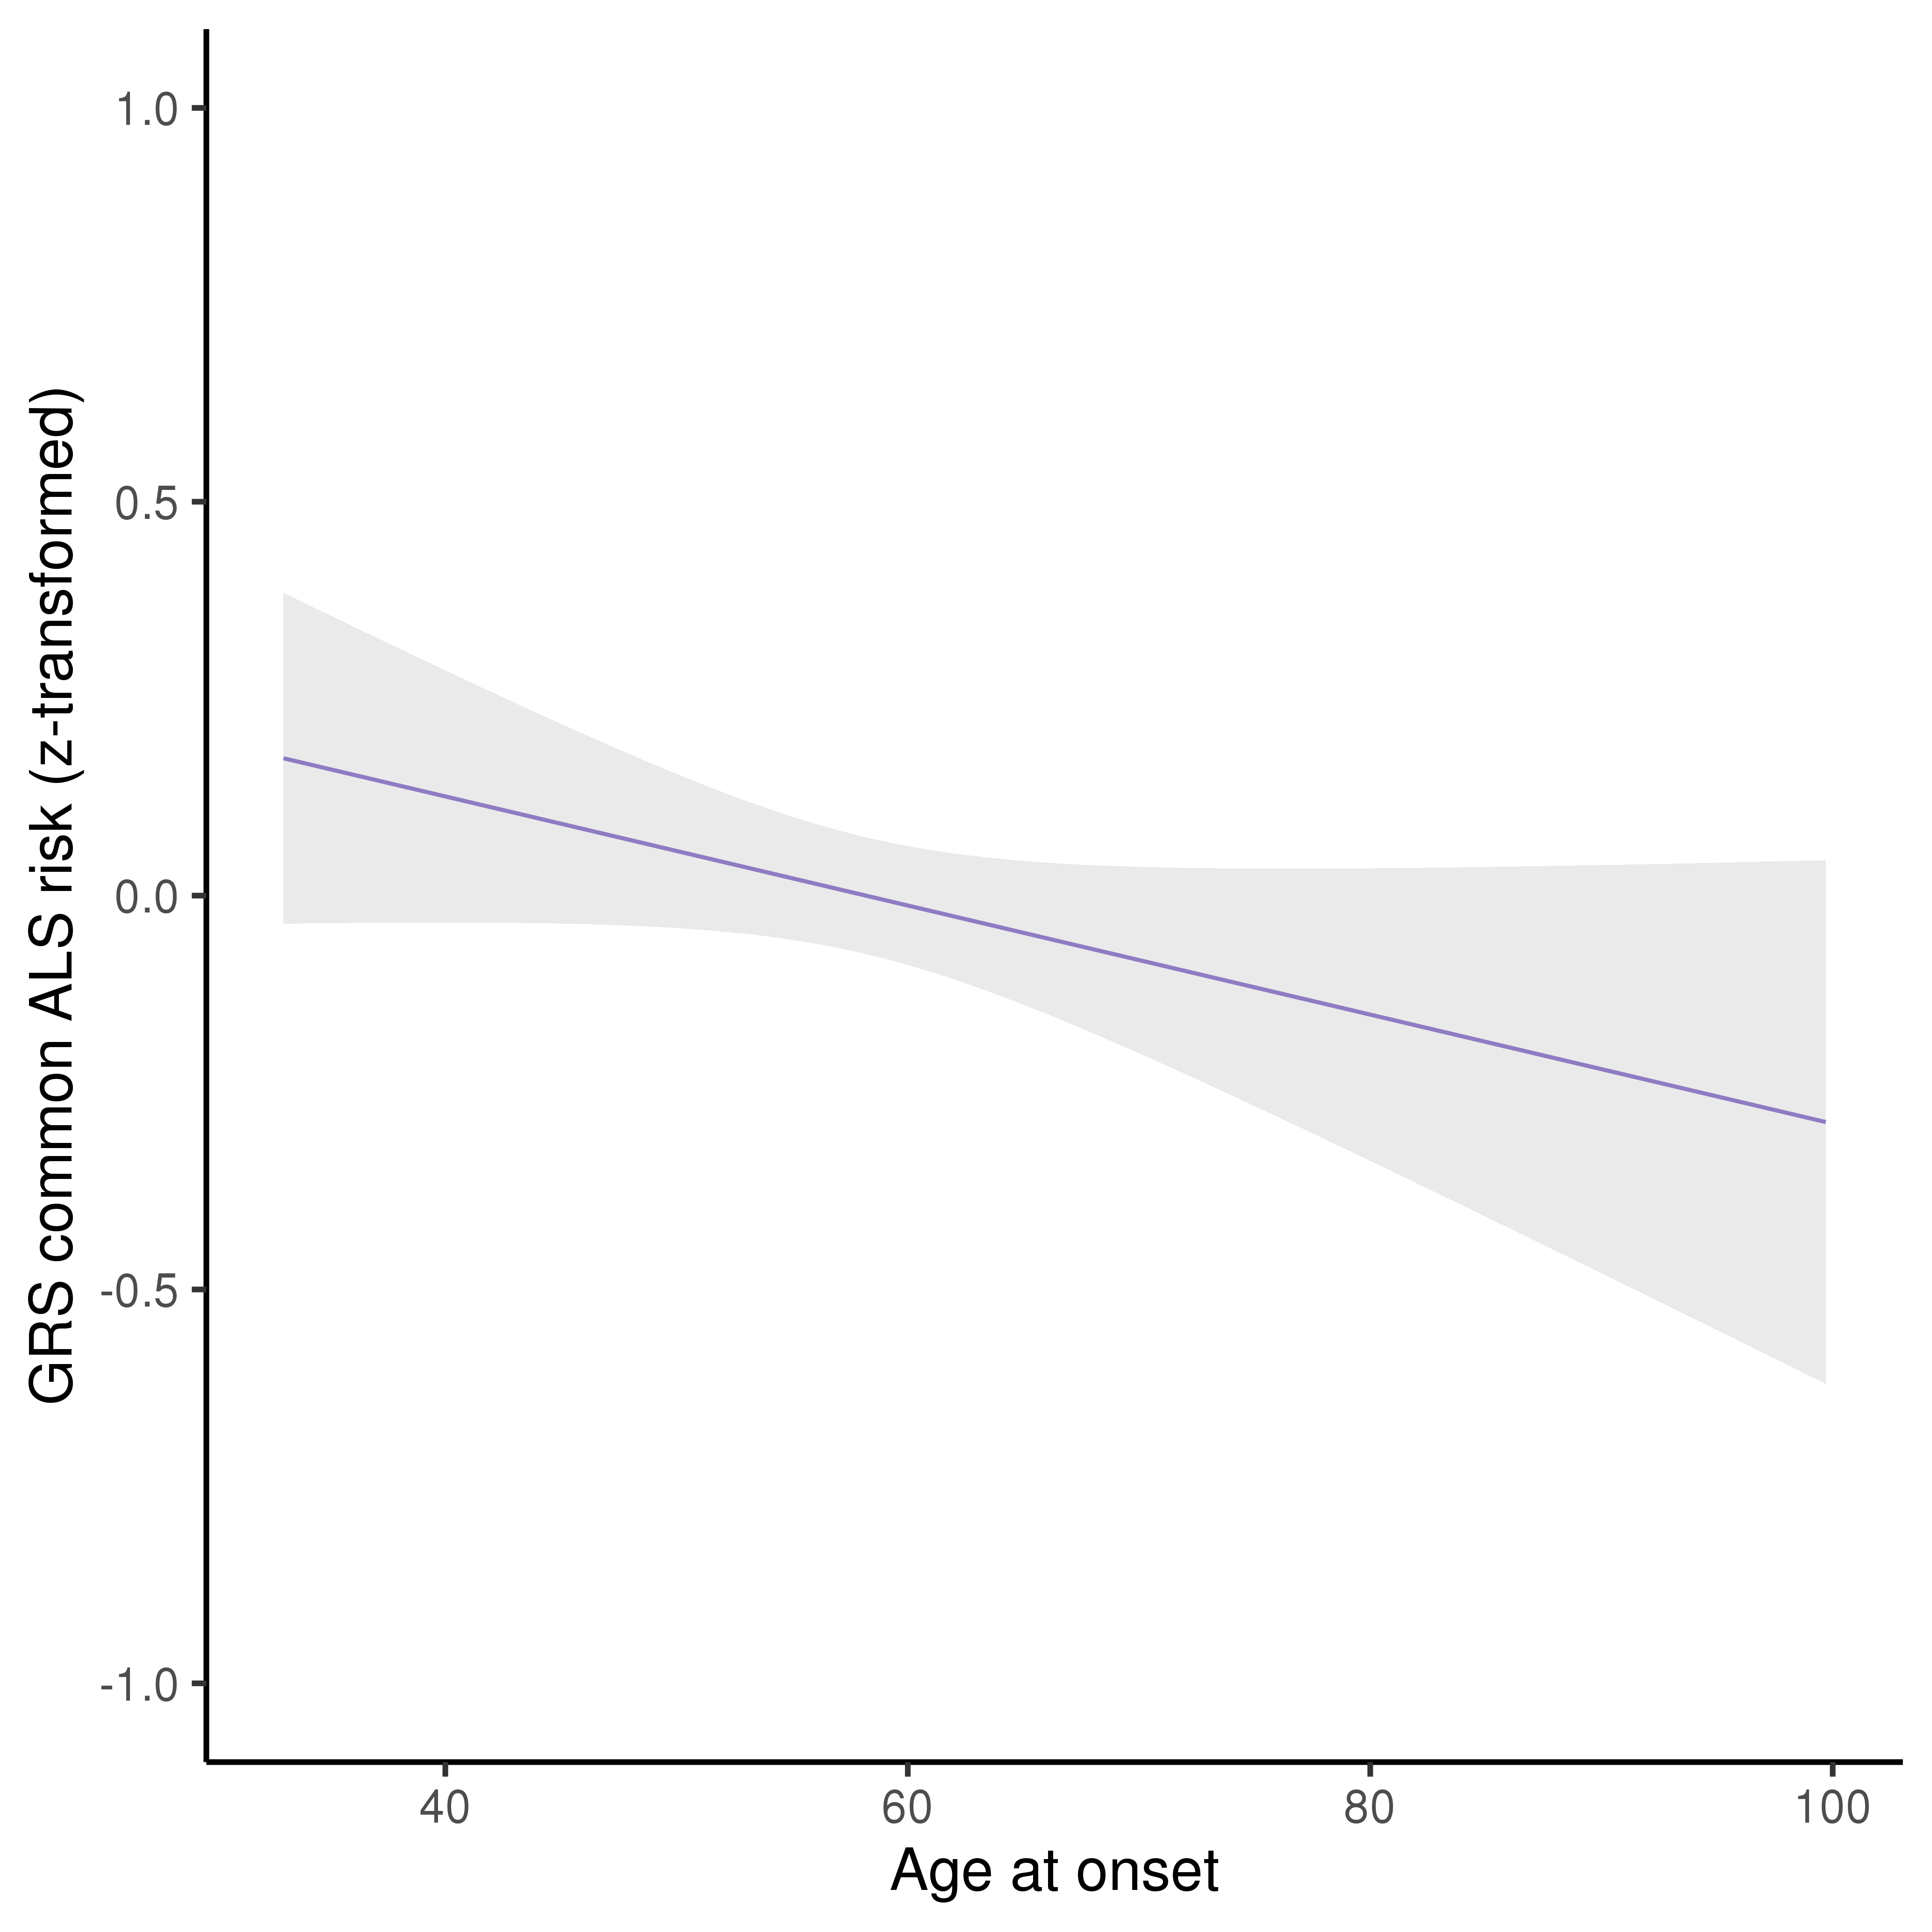

In [14]:
from IPython.display import Image
Image(filename="/data/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2021_08_17.Replication/LinealRegressioplot.Isabella.cohort.AAO.162.1.1.subt.png")



#### Meta-analysis

In [1]:
%%bash
cd /data/ALS_50k/SaraSaez_ALS/PROJECT2_C9_AAO/2020-12-2.GRS/Results
echo "C9orf72	Dataset	Beta	SE	P-value	Predictors
Carriers	Test	-0.765	0.339	0.024	161
Non-carriers	Test	0.115	0.148	0.437	161
Carriers	Replication	-0.799	0.357	0.026	147" > c9.cohorts.toforest.txt

module load R/4.0.3
R --vanilla --no-save
 
#load packages
require(data.table)
require(tidyverse)
library(meta)
 
data <- fread("c9.cohorts.toforest.txt",header=T)
data = filter(data, C9orf72 =="Carriers")
head(data)
data$labels = data$Dataset

# Plot
input <- data 
input$BETA <- input$Beta
input$SE <- input$SE
sumstats <- input
m <- metagen(BETA,
             SE,
             data=sumstats,
             studlab=Dataset,
             comb.fixed = TRUE,
             comb.random = TRUE,
             prediction=FALSE,
             level.ci = 0.95,
             sm="BETA")
             
m 
          
svg(file = '
')        
 forest(m,
       layout = "JAMA",
         leftlabs=c("Dataset", "Beta" , "(95% CI)"),
         smlab = "Beta",
        ref = 0,
    squaresize = 0.5,
                      col.square = "grey",
                      col.square.lines = "black",
                      col.diamond.fixed = "#50b0cb",
                    text.fixed = "Summary (Fixed Effects)",
                      text.random = "Summary (Random Effects)",
                      cex = 12,
                      ff.fixed = "bold",
                      ff.fixed.labels = "bold",
                      fs.hetstat = 15,
                      just.addcols = "center",
                      spacing = 1.25,
                      colgap.forest.left = unit(10,"mm"),
                      colgap.forest.right = unit(15,"mm"),
                      colgap.studlab = unit(10,"mm"),
                      plotwidth = unit(70,"mm"))
dev.off()           



[+] Loading gcc  9.2.0  ... 
[+] Loading GSL 2.6 for GCC 9.2.0 ...
[-] Unloading gcc  9.2.0  ... 
[+] Loading gcc  9.2.0  ... 
[+] Loading openmpi 3.1.4  for GCC 9.2.0 
[+] Loading ImageMagick  7.0.8  on cn1007 
[+] Loading HDF5  1.10.4 
[-] Unloading gcc  9.2.0  ... 
[+] Loading gcc  9.2.0  ... 
[+] Loading NetCDF 4.7.4_gcc9.2.0 
[+] Loading pandoc  2.16.2  on cn1007 
[+] Loading pcre2 10.21  ... 
[+] Loading R 4.0.3 



R version 4.0.3 (2020-10-10) -- "Bunny-Wunnies Freak Out"
Copyright (C) 2020 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>  
> #load packages
> require(data.table)


Loading required package: data.table


> require(tidyverse)


Loading required package: tidyverse
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()


> library(meta)


Loading 'meta' package (version 4.18-0).
Type 'help(meta)' for a brief overview.


>  
> data <- fread("c9.cohorts.toforest.txt",header=T)
> data = filter(data, C9orf72 =="Carriers")
> head(data)
    C9orf72     Dataset   Beta    SE P-value Predictors
1: Carriers        Test -0.765 0.339   0.024        161
2: Carriers Replication -0.799 0.357   0.026        147
> data$labels = data$Dataset
> 
> # Plot
> input <- data 
> input$BETA <- input$Beta
> input$SE <- input$SE
> sumstats <- input
> m <- metagen(BETA,
+              SE,
+              data=sumstats,
+              studlab=Dataset,
+              comb.fixed = TRUE,
+              comb.random = TRUE,
+              prediction=FALSE,
+              level.ci = 0.95,
+              sm="BETA")
>              
> m 
               BETA             95%-CI %W(fixed) %W(random)
Test        -0.7650 [-1.4294; -0.1006]      52.6       52.6
Replication -0.7990 [-1.4987; -0.0993]      47.4       47.4

Number of studies combined: k = 2

                        BETA             95%-CI     z p-value
Fixed effect model   -0.7811 [